In [1]:
import sys
sys.path

sys.path.append("/anaconda/envs/azureml_py38/lib/python3.8/site-packages")
sys.path.append("/anaconda/envs/azureml_py38/lib/python3.8/site-packages")

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_poisson_deviance
import pickle
import os

In [2]:
chemicals = [
    'aluminium',
    'phosphorus',
    'ph',
    'exchangeable_acidity',
     'calcium',
    'magnesium',
    'sulphur', 
    'sodium',
    'iron', 
    'manganese',
    'boron', 
    'copper', 
    'zinc', 
    'total_nitrogen', 
    'potassium',
    'ec_salts', 
    'organic_carbon', 'cec',
     'sand'
      ,'silt', 'clay'
]


In [3]:
df = pd.DataFrame()
difference_thresholds = {}
for chem in chemicals:
    df_pcc1 = pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/{chem}.csv")
    df_pcc2 = pd.read_csv(f"outputFiles/PCC2_Classes_Reconstructed/{chem}.csv")
    thresholds = pd.DataFrame(df_pcc1.Difference.describe().T)
    
    thresholds = thresholds.drop('count')
    thresholds = thresholds.drop('std')
    metrics = []
    tps = []
    tns = []
    fps = []
    fns = []
    percentiles = [i for i in (np.arange(10, 110, 10))]
    
    
    for value in percentiles:
        metrics.append(value)
        val = value / 100
        tps.append(len(df_pcc2.loc[df_pcc2['Difference'] >= np.quantile(df_pcc2['Difference'], val)]))
        tns.append(len(df_pcc1.loc[df_pcc1['Difference'] < np.quantile(df_pcc2['Difference'], val)]))
        fps.append(len(df_pcc1.loc[df_pcc1['Difference'] >= np.quantile(df_pcc2['Difference'], val)]))
        fns.append(len(df_pcc2.loc[df_pcc2['Difference'] < np.quantile(df_pcc2['Difference'], val)]))
#     chem_
    chem_df = pd.DataFrame({"chemical":chem, "percentile":metrics,"TP": tps,"TN": tns,"FP": fps,"FN": fns, "outliers":len(df_pcc2), "normal":len(df_pcc1)})
    df = pd.concat([df, chem_df])

In [4]:
df.T.to_csv("DecisionMatrix.csv")

In [5]:
df

,chemical,percentile,TP,TN,FP,FN,outliers,normal
0,aluminium,10,11,157,1254,2,13,1411
1,aluminium,20,10,388,1023,3,13,1411
2,aluminium,30,9,479,932,4,13,1411
3,aluminium,40,8,657,754,5,13,1411
4,aluminium,50,7,1034,377,6,13,1411
...,...,...,...,...,...,...,...,...
5,clay,60,7,1259,164,9,16,1423
6,clay,70,5,1282,141,11,16,1423
7,clay,80,4,1311,112,12,16,1423
8,clay,90,2,1367,56,14,16,1423


In [2]:
chemical = "aluminium"

In [3]:
df_pcc1 = pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/{chemical}.csv")
df_pcc2 = pd.read_csv(f"outputFiles/PCC2_Classes_Reconstructed/{chemical}.csv")

In [6]:
df_pcc1['Difference'].describe()

count    1411.000000
mean      109.404673
std       112.838073
min         0.036730
25%        34.286475
50%        75.168180
75%       144.438100
max      1081.003740
Name: Difference, dtype: float64

In [7]:
 
 
    differences_threshold = {
        "aluminium": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/aluminium.csv")['Difference'].describe()['50%'],
        "magnesium": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/magenesium.csv")['Difference'].describe()['mean'],
        "boron": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/boron.csv")['Difference'].describe()['mean'],
        "sodium": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/sodium.csv")['Difference'].describe()['75%'],
        "iron": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/iron.csv")['Difference'].describe()['75%'],
        "potassium": pd.read_csv(f"outputFiles/PCC1_Classes_Reconstructed/potassium.csv")['Difference'].describe()['50%'],
    }

FileNotFoundError: [Errno 2] No such file or directory: 'outputFiles/PCC1_Classes_Reconstructed/magenesium.csv'

In [51]:
def true_positive(metric ,threshold, count):
    print(metric)
    print(threshold)
    print(count)
    percent_correctly_classified = len(df_pcc2.loc[df_pcc2['Difference'] > threshold]) / len (df_pcc2)
    print(f"Percentage of correct true positive: {percent_correctly_classified}")
    count_correctly_classified = percent_correctly_classified * count
    print(f"Number of correctly classified: {count_correctly_classified}")
    
    cost_of_tp = 100 * count_correctly_classified
    print(f"Cost of tp: {cost_of_tp}")
    
    count_wrongly_classified = count - count_correctly_classified
    print(f"Number of wrongly classified: {count_wrongly_classified}")
    cost_of_fp = 200 * count_wrongly_classified
    print(f"Cost of fp: {cost_of_fp}")

In [52]:
def true_negative(metric, threshold, count):
    print(metric)
    print(threshold)
    print(count)
    percent_correctly_classified = len(df_pcc1.loc[df_pcc1['Difference'] < threshold]) / len (df_pcc1)
    print(f"Percentage of correct true negative: {percent_correctly_classified}")
    count_correctly_classified = percent_correctly_classified * count
    print(f"Number of correctly classified: {count_correctly_classified}")
    
    cost_of_tn = 100 * count_correctly_classified
    print(f"Cost of tn: {cost_of_tn}")
    
    count_wrongly_classified = count - count_correctly_classified
    print(f"Number of wrongly classified: {count_wrongly_classified}")
    cost_of_fn = 101.50 * count_wrongly_classified
    print(f"Cost of fn: {cost_of_fn}")

In [53]:
for index,val in (df_pcc1.Difference.describe().to_frame()).iterrows():
    if(index == "count" or index == "std"):
        continue
    true_positive(index, val['Difference'],df_pcc2.Difference.describe().to_frame().T['count'][0])
    print("=============================>")


mean
109.40467268887315
12.0
Percentage of correct true positive: 0.5
Number of correctly classified: 6.0
Cost of tp: 600.0
Number of wrongly classified: 6.0
Cost of fp: 1200.0
=============================>
min
0.0367299999999204
12.0
Percentage of correct true positive: 1.0
Number of correctly classified: 12.0
Cost of tp: 1200.0
Number of wrongly classified: 0.0
Cost of fp: 0.0
=============================>
25%
34.28647499999997
12.0
Percentage of correct true positive: 0.75
Number of correctly classified: 9.0
Cost of tp: 900.0
Number of wrongly classified: 3.0
Cost of fp: 600.0
=============================>
50%
75.16818
12.0
Percentage of correct true positive: 0.6666666666666666
Number of correctly classified: 8.0
Cost of tp: 800.0
Number of wrongly classified: 4.0
Cost of fp: 800.0
=============================>
75%
144.43809999999996
12.0
Percentage of correct true positive: 0.3333333333333333
Number of correctly classified: 4.0
Cost of tp: 400.0
Number of wrongly classified: 8

In [54]:
for index,val in (df_pcc1.Difference.describe().to_frame()).iterrows():
    if(index == "count" or index == "std"):
        continue
    true_negative(index, val['Difference'],df_pcc1.Difference.describe().to_frame().T['count'][0])
    print("=============================>")


mean
109.40467268887315
1411.0
Percentage of correct true negative: 0.6477675407512402
Number of correctly classified: 913.9999999999999
Cost of tn: 91399.99999999999
Number of wrongly classified: 497.0000000000001
Cost of fn: 50445.500000000015
=============================>
min
0.0367299999999204
1411.0
Percentage of correct true negative: 0.0
Number of correctly classified: 0.0
Cost of tn: 0.0
Number of wrongly classified: 1411.0
Cost of fn: 143216.5
=============================>
25%
34.28647499999997
1411.0
Percentage of correct true negative: 0.25017717930545713
Number of correctly classified: 353.0
Cost of tn: 35300.0
Number of wrongly classified: 1058.0
Cost of fn: 107387.0
=============================>
50%
75.16818
1411.0
Percentage of correct true negative: 0.49964564138908574
Number of correctly classified: 705.0
Cost of tn: 70500.0
Number of wrongly classified: 706.0
Cost of fn: 71659.0
=============================>
75%
144.43809999999996
1411.0
Percentage of correct true

In [13]:
chemical = 'sodium'

In [14]:
df_pcc1 = pd.read_csv(f"outputFiles/PCC1/test/{chemical}.csv", index_col=0)
df_pcc1_rec = pd.read_csv(f"outputFiles/pcc1_reconstructed_spc/{chemical}.csv", index_col=0)

In [15]:
df_pcc1

,522,524,526,528,530,532,534,536,538,540,...,3958,3960,3962,3964,3966,3968,3970,3972,3974,3976
AGD510-234SA0001,2.174711,2.145821,2.098355,2.114455,2.159439,2.179593,2.169110,2.162929,2.161636,2.145576,...,1.344118,1.344749,1.344592,1.344313,1.344660,1.344322,1.342737,1.341157,1.339952,1.339333
AGD510-240SA0001,2.039150,2.030622,2.061852,2.082355,2.086400,2.078127,2.053211,2.027267,2.019875,2.022030,...,1.323353,1.323315,1.323458,1.322996,1.322033,1.321480,1.321788,1.321788,1.320924,1.320102
AGD510-244SA0001,2.140660,2.098375,2.074247,2.069894,2.097792,2.127162,2.125677,2.100697,2.063571,2.043263,...,1.446732,1.447499,1.447270,1.446043,1.445250,1.444685,1.444066,1.443906,1.443830,1.443276
AGD510-250SA0001,2.123585,2.130429,2.117540,2.075244,2.035210,2.026893,2.041763,2.070710,2.092264,2.086837,...,1.398546,1.397395,1.395755,1.394896,1.394889,1.395048,1.395079,1.394863,1.394376,1.394179
AGD510-251SA0001,2.116350,2.098201,2.065171,2.034715,2.025064,2.021206,2.018723,2.025845,2.023001,2.001123,...,1.372099,1.372609,1.371910,1.370914,1.370254,1.369640,1.368987,1.369074,1.369906,1.369701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CE066SA1160,2.322344,2.253507,2.233875,2.258246,2.256221,2.226924,2.219880,2.237171,2.239834,2.217226,...,1.480779,1.479003,1.478439,1.478555,1.478445,1.477518,1.475985,1.474887,1.474819,1.475155
CE066SA1172,2.275026,2.251941,2.225063,2.221025,2.218898,2.215343,2.209046,2.192925,2.167932,2.159076,...,1.572849,1.571539,1.571110,1.570968,1.570019,1.568293,1.566647,1.565661,1.565425,1.565186
CE066SA1183,2.299221,2.284305,2.317055,2.371397,2.352940,2.298327,2.257776,2.219900,2.193878,2.196357,...,1.468984,1.468440,1.468167,1.467660,1.467030,1.466568,1.465725,1.464176,1.462816,1.462218
CE066SA1193,2.400721,2.518490,2.479228,2.388354,2.366905,2.376425,2.365430,2.364218,2.397531,2.403456,...,1.441550,1.441782,1.441535,1.440415,1.439378,1.438801,1.437777,1.436080,1.434830,1.434811


In [16]:
df_pcc1_rec

,0,1,2,3,4,5,6,7,8,9,...,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727
AGD510-234SA0001,2.165190,2.166491,2.168809,2.171074,2.175286,2.179543,2.174282,2.165924,2.168675,2.168817,...,1.345208,1.344956,1.344621,1.344372,1.343691,1.343379,1.343030,1.342353,1.342201,1.341352
AGD510-240SA0001,2.089667,2.081926,2.080895,2.083350,2.077974,2.074722,2.069374,2.063204,2.059236,2.062200,...,1.322293,1.322121,1.322130,1.321964,1.321168,1.321384,1.321242,1.320837,1.320579,1.320389
AGD510-244SA0001,2.107853,2.105592,2.106450,2.100483,2.093688,2.083711,2.074405,2.070486,2.062969,2.066585,...,1.448556,1.447922,1.447426,1.446806,1.446878,1.446659,1.446779,1.445923,1.445236,1.444654
AGD510-250SA0001,2.136190,2.123338,2.114054,2.115241,2.109408,2.108364,2.100518,2.094095,2.092062,2.092212,...,1.396714,1.396371,1.396598,1.396242,1.395703,1.395734,1.395333,1.395139,1.394858,1.394385
AGD510-251SA0001,2.107718,2.102648,2.087347,2.089297,2.076630,2.059628,2.048638,2.036102,2.028034,2.023567,...,1.373253,1.372759,1.373277,1.372545,1.372034,1.371426,1.370858,1.371201,1.370140,1.370109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CE066SA1160,2.336242,2.321483,2.303105,2.281256,2.261810,2.245270,2.244625,2.235405,2.225010,2.230556,...,1.482231,1.481299,1.480521,1.479651,1.478923,1.477801,1.476496,1.476069,1.475305,1.474667
CE066SA1172,2.313618,2.300371,2.284821,2.262675,2.249389,2.224791,2.213571,2.199552,2.184560,2.184641,...,1.574350,1.573561,1.572367,1.571568,1.570672,1.569426,1.567692,1.567052,1.565688,1.564499
CE066SA1183,2.339276,2.321826,2.310804,2.289480,2.274135,2.255784,2.248329,2.237749,2.229445,2.226106,...,1.468717,1.468260,1.468204,1.467237,1.466125,1.465272,1.464318,1.463650,1.462928,1.462697
CE066SA1193,2.461206,2.448406,2.434773,2.418389,2.403410,2.385807,2.384415,2.385740,2.373399,2.373646,...,1.440805,1.440423,1.440143,1.439448,1.438726,1.437543,1.437036,1.435960,1.435684,1.434733


In [17]:
df_pcc1_t = df_pcc1.T
df_pcc1_rec_t = df_pcc1_rec.T

In [72]:
r2_scores = []
maes = []
mapes = []
mses = []
mpds = []
for i in df_pcc1_t:
    print(i)
    
    r2_scores.append(r2_score(df_pcc1_t[i].values, df_pcc1_rec_t[i].values))
    maes.append(mean_absolute_error(df_pcc1_t[i].values, df_pcc1_rec_t[i].values))
    mapes.append(mean_absolute_percentage_error(df_pcc1_t[i].values, df_pcc1_rec_t[i].values))
    mses.append(mean_squared_error(df_pcc1_t[i].values, df_pcc1_rec_t[i].values))
    mpds.append(mean_poisson_deviance(df_pcc1_t[i].values, df_pcc1_rec_t[i].values))

AGD510-234SA0001
AGD510-240SA0001
AGD510-244SA0001
AGD510-250SA0001
AGD510-251SA0001
AGD510-264SA0001
AGD510-281SA0001
AGD510-288SA0001
AGD510-311SA0001
AGD510-315SA0001
AGD510-320SA0001
AGD510-325SA0001
AGD510-334SA0001
AGD517-116SA0001
AGD517-129SA0001
AGD517-129SA0003
AGD517-129SA0007
AGD517-129SA0010
AGD517-129SA0011
AGD517-129SA0016
AGD517-130SA0001
AGD517-151SA0001
CA002SA0619
CA002SA0620
CA002SA0622
CA002SA0628
CA002SA0632
CA002SA0635
CA004SA0081
CA004SA0082
CA014SA0164
CA028SA0476
CA028SA0495
CA028SA0498
CA028SA0509
CA052SA0442
CA052SA0445
CA052SA0448
CA052SA0465
CA052SA0473
CA052SA0475
CA052SA0478
CA053SA0991
CA053SA0997
CA053SA0998
CA053SA0999
CA053SA1020
CA053SA1030
CA053SA1034
CA053SA1048
CA053SA1056
CA053SA1068
CA053SA1069
CA053SA1079
CA053SA1080
CA053SA1106
CA053SA1112
CA053SA1118
CA053SA1133
CA053SA1134
CA053SA1148
CA053SA1153
CA053SA1156
CA053SA1173
CA053SA1182
CA053SA1194
CA053SA1195
CA053SA1210
CA053SA1213
CA053SA1216
CA053SA1245
CA053SA1251
CA053SA1258
CA053SA1280
CA

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.

<Axes: >

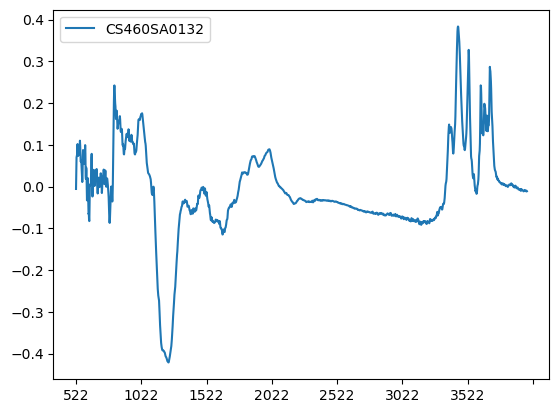

In [75]:
df_pcc1.loc[df_pcc1.index == 'CS460SA0132'].T.plot()

<Axes: >

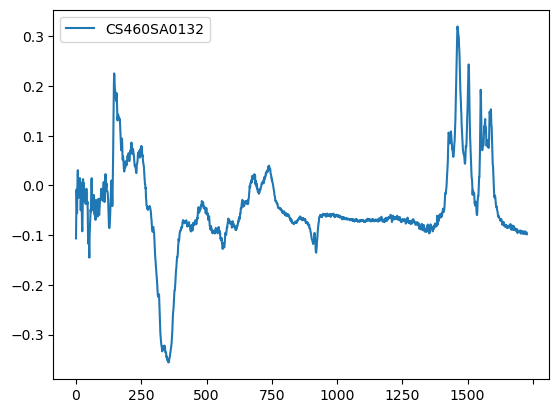

In [76]:
df_pcc1_rec.loc[df_pcc1_rec.index == 'CS460SA0132'].T.plot()

In [25]:
df_pcc2 = pd.read_csv(f"outputFiles/PCC2/{chemical}.csv", index_col=0)
df_pcc2_rec = pd.read_csv(f"outputFiles/pcc2_reconstructed_spc/{chemical}.csv", index_col=0)

In [26]:
df_pcc2_t = df_pcc2.T
df_pcc2_rec_t = df_pcc2_rec.T

In [42]:
r2_scores_pcc2 = []
maes_pcc2 = []
mapes_pcc2 = []
mses_pcc2 = []

for i in df_pcc2_t:
    print(i)
    r2_scores_pcc2.append(r2_score(df_pcc2_t[i].values, df_pcc2_rec_t[i].values))
    maes_pcc2.append(mean_absolute_error(df_pcc2_t[i].values, df_pcc2_rec_t[i].values))
    mapes_pcc2.append(mean_absolute_percentage_error(df_pcc2_t[i].values, df_pcc2_rec_t[i].values))
    mses_pcc2.append(mean_squared_error(df_pcc2_t[i].values, df_pcc2_rec_t[i].values))

AGD510-246SA0001
AGD510-251SA0001
AGD510-299SA0001
AGD510-329SA0001
CC003SA0081
CC003SA0082
CK477SA0001
CL093SA0199
CL093SA0209
CL093SA0247
CL093SA0278
CL093SA0279
CL093SA0280
CL093SA0281
CL093SA0282
CM217SA0104
CM217SA0107
CM217SA0108
CM217SA0109
CM217SA0110
CM217SA0111
CM217SA0112
CM217SA0113
CM217SA0114
CM217SA0115
CN247SA0009
CN247SA0013
CN247SA0015
CN247SA0016
CN247SA0017
CN247SA0020
CN247SA0024
CN247SA0031
CN292SA0001
CP331SA0017
CP331SA0022
CP331SA0036
CS330SA0001
CT214SA0401
CT214SA0402
CT214SA0403
CT214SA0413
CT214SA0414
CT214SA0415
CT214SA0423
CT214SA0428
CT214SA0429
CT214SA0430
CT214SA0431
CT214SA0436
CT214SA0437
CT214SA0438
CT214SA0441
CT214SA0442
CT214SA0443
CT214SA0448
CT214SA0449
CT214SA0452
CT214SA0453
CT214SA0454
CT214SA0455
CT214SA0460
CT214SA0461
CT214SA0462
CT214SA0463
CT214SA0467
CT214SA0468
CT214SA0469
CT214SA0470
CT214SA0471
CT214SA0472
CT214SA0473
CT214SA0474
CT214SA0479
CT214SA0493
CT214SA0494
CT214SA0495
CT214SA0497
CT214SA0498
CT214SA0499
CT214SA0501
CT214SA0

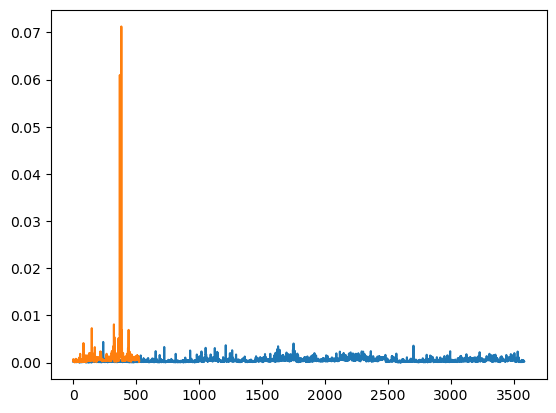

In [43]:
plt.plot(mses)
plt.plot(mses_pcc2)
plt.show()

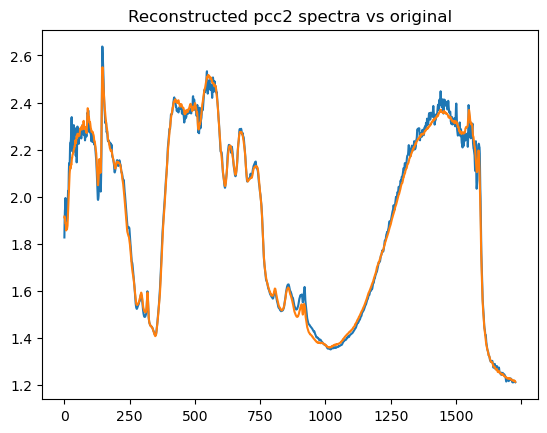

In [61]:
plt.clf()
df_pcc2.iloc[150].plot()
df_pcc2_rec.iloc[150].plot()
plt.title("Reconstructed pcc2 spectra vs original")
plt.savefig(f"outputFiles/visualizations/{chemical}_reconstructed_pcc2_spectra.png")

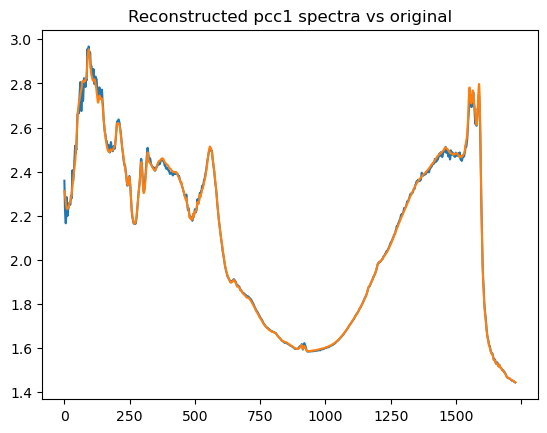

In [60]:
plt.clf()
df_pcc1.iloc[150].plot()
df_pcc1_rec.iloc[150].plot()
plt.title("Reconstructed pcc1 spectra vs original")
plt.savefig(f"outputFiles/visualizations/{chemical}_reconstructed_pcc1_spectra.png")

In [45]:
df_orig_metrics = pd.DataFrame({"maes":maes,"mapes":maes,"mses":mses}, index=df_pcc1.index)
df_rec_metrics = pd.DataFrame({ "maes_pcc2":maes_pcc2,"mapes_pcc2":mapes_pcc2,"mses_pcc2":mses_pcc2}, index=df_pcc2.index)

In [47]:
df_orig_metrics.describe()

,maes,mapes,mses
count,3585.000000,3585.000000,3585.000000
mean,0.012707,0.012707,0.000515
std,0.004877,0.004877,0.000417
min,0.003734,0.003734,0.000040
25%,0.009159,0.009159,0.000240
50%,0.011866,0.011866,0.000389
75%,0.015274,0.015274,0.000650
max,0.040177,0.040177,0.004394


In [48]:
df_rec_metrics.describe()

,maes_pcc2,mapes_pcc2,mses_pcc2
count,525.000000,525.000000,525.000000
mean,0.019567,0.009497,0.001284
std,0.016582,0.008001,0.004681
min,0.005406,0.002704,0.000089
25%,0.013232,0.006156,0.000431
50%,0.017009,0.008173,0.000669
75%,0.021349,0.010440,0.001084
max,0.221590,0.099987,0.071267


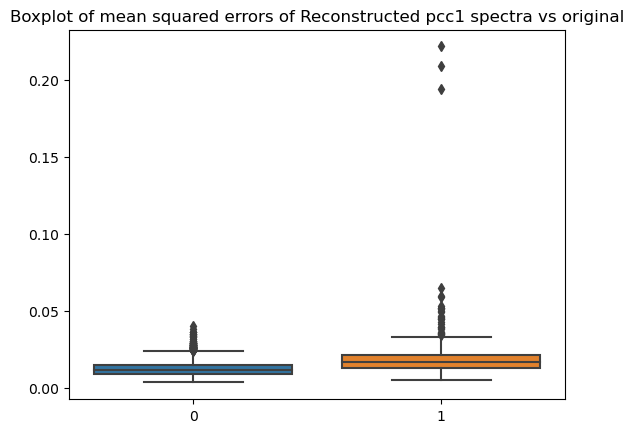

In [69]:
sns.boxplot(data=[df_orig_metrics['maes'], df_rec_metrics['maes_pcc2']])

plt.title("Boxplot of mean squared errors of Reconstructed pcc1 spectra vs original")
plt.savefig(f"outputFiles/visualizations/{chemical}_mses_boxplots.png")


In [56]:
# plt.boxplot(df_rec_metrics)

In [77]:
history = pickle.load(open('history.pkl','rb'))

2024-03-06 09:53:27.022469: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 09:53:27.024730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 09:53:27.066281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 09:53:27.067383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 09:53:28.344476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [80]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

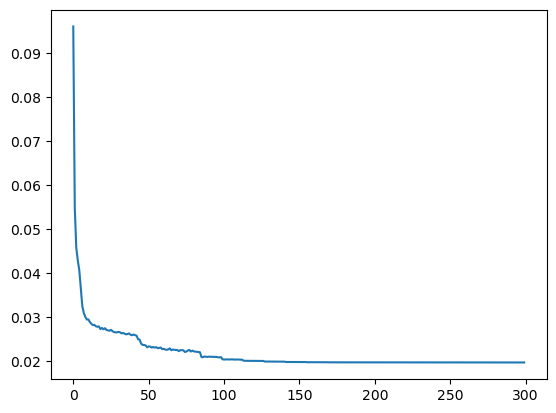

In [81]:
plt.plot(history.history['loss'])

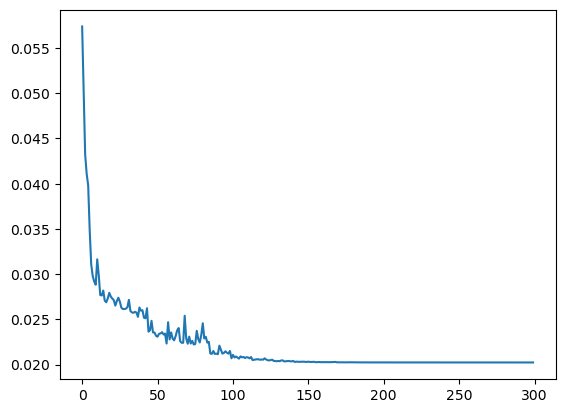

In [82]:
plt.plot(history.history['val_loss'])

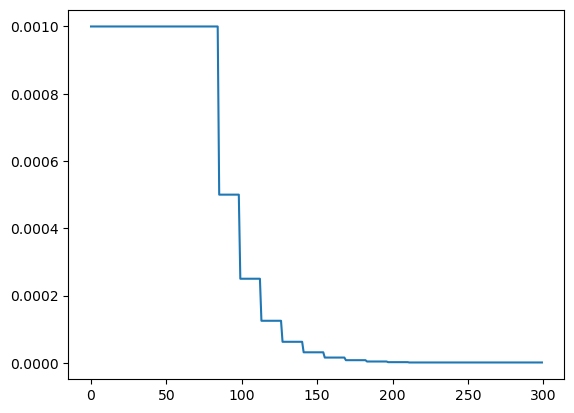

In [83]:
plt.plot(history.history['lr'])

In [74]:
dir_ = os.path.abspath("D://home/tom/data_input/MSSC_DVC/snapshots/9")

In [75]:
dir_

'D:\\home\\tom\\data_input\\MSSC_DVC\\snapshots\\9'

In [69]:
models = Path(dir_).glob('**/*.h5')

In [70]:
[i for i in models]

[]

In [71]:
str(dir_).split("\\")

['D:', 'home', 'tom', 'data_input', 'MSSC_DVC', 'snapshots', '9']

In [79]:
while (True):
    print(dir_)
    all_models = Path(dir_).glob('**/*.h5')
    if (len([i for i in all_models]) > 0):
        break
    split_dir = str(dir_).split("\\")
    last_trial = int(split_dir[-1]) - 1
    split_dir = split_dir[:-1]
    split_dir.append(str(last_trial))
    dir_ = "\\".join(split_dir)

D:\home\tom\data_input\MSSC_DVC\snapshots\9
D:\home\tom\data_input\MSSC_DVC\snapshots\8


In [76]:
splits = (dir_).split("\\")

In [78]:
splits[:-1]

['D:', 'home', 'tom', 'data_input', 'MSSC_DVC', 'snapshots']

In [100]:
arr = np.arange(0,1000,1)

In [101]:
arr

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [104]:
for i,j in zip(np.arange(0,1000, 3), np.arange(4,1000, 3)):
    print(arr[i:j-1])

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[15 16 17]
[18 19 20]
[21 22 23]
[24 25 26]
[27 28 29]
[30 31 32]
[33 34 35]
[36 37 38]
[39 40 41]
[42 43 44]
[45 46 47]
[48 49 50]
[51 52 53]
[54 55 56]
[57 58 59]
[60 61 62]
[63 64 65]
[66 67 68]
[69 70 71]
[72 73 74]
[75 76 77]
[78 79 80]
[81 82 83]
[84 85 86]
[87 88 89]
[90 91 92]
[93 94 95]
[96 97 98]
[ 99 100 101]
[102 103 104]
[105 106 107]
[108 109 110]
[111 112 113]
[114 115 116]
[117 118 119]
[120 121 122]
[123 124 125]
[126 127 128]
[129 130 131]
[132 133 134]
[135 136 137]
[138 139 140]
[141 142 143]
[144 145 146]
[147 148 149]
[150 151 152]
[153 154 155]
[156 157 158]
[159 160 161]
[162 163 164]
[165 166 167]
[168 169 170]
[171 172 173]
[174 175 176]
[177 178 179]
[180 181 182]
[183 184 185]
[186 187 188]
[189 190 191]
[192 193 194]
[195 196 197]
[198 199 200]
[201 202 203]
[204 205 206]
[207 208 209]
[210 211 212]
[213 214 215]
[216 217 218]
[219 220 221]
[222 223 224]
[225 226 227]
[228 229 230]
[231 232 233]
[234 235 236]
[2

In [94]:
len(np.arange(3,1000, 3))

333

In [95]:
len(np.arange(0,1000, 3))

334

In [125]:
un = pd.DataFrame()
bc = pd.DataFrame({'b':np.arange(0,59,1)})

In [126]:
un['a'] = np.arange(0,19,1)

In [127]:
un = pd.concat([un,pd.Series(np.arange(0,59,1))], axis=1 )

In [128]:
un

,a,0
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,5.0,5
6,6.0,6
7,7.0,7
8,8.0,8
9,9.0,9


In [13]:
sequence = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])

In [14]:
print(len(sequence))

2


In [15]:
n_in = len(sequence[0])
sequence = sequence.reshape((1, n_in, 2))

In [16]:
np.shape(sequence)

(1, 9, 2)